In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('concat.csv', index_col=0)

In [3]:
# df.drop(df.columns[-5:], axis = 1, inplace=True)
df.drop('Close', axis = 1, inplace=True)

In [4]:
df.shape

(11044005, 12)

데이터 갯수 조건에 맞지 않는 Ticker 선별

1. 데이터 갯수가 4년치 미만인 Ticker는 제거

In [5]:
del_ticker_list = df['Ticker'].value_counts()[df['Ticker'].value_counts()<=252*4].index

In [6]:
del_ticker_index = df[df['Ticker'].isin(del_ticker_list)].index

In [7]:
df_new = df.drop(del_ticker_index) 

In [8]:
df_new.shape

(10221509, 12)

In [9]:
# 강사님의 윈도우 코드 복붙(이건 우리 입맛에 나중에 바꿔도 상관없음)
def my_window_data(df, target, window_size=20):
    X_list = []
    y_list = []
    for i in range(len(df) - window_size-1):
        X = df.iloc[i:i+window_size]
        y = df.iloc[i+window_size][target]
        X_list.append(np.array(X))      #[[] ,[] ,[] ,[]]
        y_list.append(np.array(y))       #[]   
    return  np.array(X_list), np.array(y_list).reshape(-1)

In [10]:
def per_ticker_tt_split(df, target,  size = 0.7, window_size=20):
    Ticker_train_dict = {}
    Ticker_test_dict = {}
    for t in tqdm(df.Ticker.unique()[:10]):
        scaler = MinMaxScaler()
        train_size = df[df['Ticker']==t].iloc[:int(len(df[df.Ticker==t])*size)].drop('Ticker', axis = 1)
        train_size['Datetime'] = pd.to_datetime(train_size['Datetime'])
        train_size.set_index('Datetime', inplace = True)
        scaler.fit(train_size)
        train_size = pd.DataFrame(columns = train_size.columns, data = scaler.transform(train_size))
        test_size = df[df['Ticker']==t].iloc[int(len(df[df.Ticker==t])*size):].drop('Ticker', axis = 1)
        test_size['Datetime'] = pd.to_datetime(test_size['Datetime'])
        test_size.set_index('Datetime', inplace = True)
        test_size = pd.DataFrame(columns = test_size.columns, data = scaler.transform(test_size))

        X_train, y_train = my_window_data(train_size, target, window_size)
        X_test , y_test  = my_window_data(test_size, target, window_size)
        Ticker_train_dict[f'{t}_X_train'], Ticker_train_dict[f'{t}_y_train'] = X_train, y_train
        Ticker_test_dict[f'{t}_X_test'], Ticker_test_dict[f'{t}_y_test'] = X_test , y_test
    return Ticker_train_dict, Ticker_test_dict

In [11]:
train_dict, test_dict = per_ticker_tt_split(df = df_new, target='Adj Close')

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [12]:
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, Ticker, mode = 'train'):
        self.Ticker = Ticker
        if mode == 'train':
            self.X = torch.tensor(train_dict[f'{Ticker}_X_{mode}']).float()
            self.y = torch.tensor(train_dict[f'{Ticker}_y_{mode}']).float()
        elif mode == 'test':
            self.X = torch.tensor(test_dict[f'{Ticker}_X_{mode}']).float()
            self.y = torch.tensor(test_dict[f'{Ticker}_y_{mode}']).float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [13]:
from torch import nn
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [14]:
feature_num = len(df.columns)
hidden_dim = 10
output_dim = 1 
device = 'cpu'

In [15]:
import torch
from torch.utils.data import DataLoader # 데이터로더


In [16]:
def training(epoch, model, train_loader ):
    running_loss = 0

    model.train()
    for idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader. dataset)
    return epoch_loss
    
def testing(epoch, model,valid_loader):
    valid_running_loss = 0
    model.eval()
    with torch.no_grad():
        for idx, (X, y) in enumerate(valid_loader):
             X, y = X.to(device), y.to(device)
             y_pred = model(X)
             loss = loss_fn(y_pred, y)
             valid_running_loss += loss.item()
    epoch_valid_loss = valid_running_loss / len(valid_loader.dataset)
    # print(f'epoch:{epoch},\nloss:{round(epoch_loss, 3)},valid_loss:{round(epoch_valid_loss, 3)}')
    return epoch_valid_loss

In [17]:
model = Net(feature_num, hidden_dim, 20, output_dim, 1).to(device)  

In [18]:
ticker_list = list(df_new['Ticker'].unique())

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [20]:
epochs = 100
pbar = tqdm(range(epochs))
total_loss = []
total_val_loss = []
for epoch in pbar:
        loss_list = []
        val_loss_list = []
        for ticker in ticker_list[:10]:
                train_dataset = StockDataset(ticker, mode = 'train')
                valid_dataset = StockDataset(ticker, mode = 'test')
                batch = 20
                loss_fn = nn.MSELoss().to(device)
                train_loader = DataLoader(train_dataset,
                                batch_size = batch,
                                shuffle = False,  
                                drop_last = True)
                valid_loader = DataLoader(valid_dataset,
                                batch_size = batch,
                                shuffle = False,  
                                drop_last = True) 
                
                loss = training(epoch, model, train_loader)
                valid_loss = testing(epoch, model, valid_loader)
                loss_list.append(loss)
                val_loss_list.append(valid_loss)
        print(f'Epoch{str(epoch).zfill(3)}\t\t loss : {round((np.mean(loss_list)), 3)}, valid loss : {round(np.mean(val_loss_list), 3)}')
        total_loss.append(np.mean(loss_list))
        total_val_loss.append(np.mean(val_loss_list))

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 10

In [ ]:
test_dict.keys()

dict_keys(['AACG_X_test', 'AACG_y_test', 'AADI_X_test', 'AADI_y_test', 'AAL_X_test', 'AAL_y_test', 'AAME_X_test', 'AAME_y_test', 'AAOI_X_test', 'AAOI_y_test', 'AAON_X_test', 'AAON_y_test', 'AAPL_X_test', 'AAPL_y_test', 'AATC_X_test', 'AATC_y_test', 'AAWW_X_test', 'AAWW_y_test', 'ABCB_X_test', 'ABCB_y_test'])

In [ ]:
test_dataset = StockDataset('AAPL', mode = 'test')
test_loader = DataLoader(test_dataset,
                # batch_size = batch,
                shuffle = False,  
                drop_last = True) 

In [ ]:
pred = []
true = []
model.eval()
with torch.no_grad():
    for idx, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            true.append(y)
            print(idx, model(X))
            pred.append(model(X))

0 tensor([[0.8223]])
1 tensor([[0.8197]])
2 tensor([[0.8199]])
3 tensor([[0.8187]])
4 tensor([[0.8150]])
5 tensor([[0.8117]])
6 tensor([[0.8115]])
7 tensor([[0.8215]])
8 tensor([[0.8239]])
9 tensor([[0.8239]])
10 tensor([[0.8225]])
11 tensor([[0.8196]])
12 tensor([[0.8213]])
13 tensor([[0.8186]])
14 tensor([[0.8121]])
15 tensor([[0.8088]])
16 tensor([[0.8060]])
17 tensor([[0.8050]])
18 tensor([[0.8015]])
19 tensor([[0.7970]])
20 tensor([[0.7958]])
21 tensor([[0.7997]])
22 tensor([[0.8070]])
23 tensor([[0.8081]])
24 tensor([[0.8033]])
25 tensor([[0.8045]])
26 tensor([[0.8074]])
27 tensor([[0.8096]])
28 tensor([[0.8074]])
29 tensor([[0.8080]])
30 tensor([[0.7853]])
31 tensor([[0.7738]])
32 tensor([[0.7661]])
33 tensor([[0.7600]])
34 tensor([[0.7573]])
35 tensor([[0.7573]])
36 tensor([[0.7585]])
37 tensor([[0.7591]])
38 tensor([[0.7637]])
39 tensor([[0.7697]])
40 tensor([[0.7767]])
41 tensor([[0.7807]])
42 tensor([[0.7870]])
43 tensor([[0.7912]])
44 tensor([[0.7954]])
45 tensor([[0.7936]]

/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


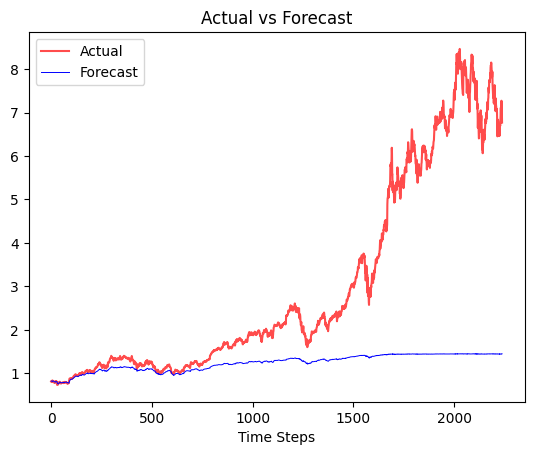

In [ ]:
import matplotlib.pyplot as plt
plt.plot(true, color='red', alpha=0.7)
plt.plot(pred, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [ ]:
len(y)

1

In [ ]:
true = [i.item() for i in true]

In [ ]:
# pred = [t.item() for t in pred]
forecast = pd.DataFrame({'yhat':pred, 'y':true})

In [ ]:
forecast

,yhat,y
0,0.822258,0.812348
1,0.819684,0.816871
2,0.819883,0.813173
3,0.818661,0.806955
4,0.815001,0.797657
...,...,...
2233,1.445411,6.760757
2234,1.446248,7.271897
2235,1.440075,7.159764
2236,1.444371,7.034081


In [ ]:
fore_trend = [1 if forecast['yhat'].diff().iloc[i]>0 else 0 for i in range(len(forecast))]
true_trend = [1 if forecast['y'].diff().iloc[i]>0 else 0 for i in range(len(forecast))]

In [ ]:
np.sum([1 if fore_trend[i] == true_trend[i] else 0 for i in range(len(true_trend))])/len(true_trend)

0.5008936550491511

In [ ]:
fore_trend = [1 if forecast['yhat'].diff(1).iloc[i]>0 and forecast['yhat'].diff(-1).iloc[i]>0
            else -1 if forecast['yhat'].diff(1).iloc[i]<0 and forecast['yhat'].diff(-1).iloc[i]<0
            else 0 for i in range(len(forecast))]
true_trend = [1 if forecast['y'].diff(1).iloc[i]>0 and forecast['y'].diff(-1).iloc[i]>0
            else -1 if forecast['y'].diff(1).iloc[i]<0 and forecast['y'].diff(-1).iloc[i]<0
            else 0 for i in range(len(forecast))]

In [ ]:
np.sum([1 if fore_trend[i] == true_trend[i] else 0 for i in range(len(true_trend))])/len(true_trend)

0.3614834673815907